In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí ARMA modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19*

Uvažujme datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Datová sada obsahující kumulativní denní počty osob s prokázaným onemocněním COVID-19 dle hlášení krajských hygienických stanic včetně laboratoří, denní počty vyléčených po onemocnění COVID‑19 dle hlášení krajských hygienických stanic, denní počty úmrtí v souvislosti s onemocněním COVID‑19 dle hlášení krajských hygienických stanic a hospitalizačních úmrtí, a denní počty provedených testů na onemocnění COVID-19 dle hlášení laboratoří. S ohledem na fakt, že vykazování vyléčených osob a úmrtí má určité zpoždění oproti reálnému stavu z důvodu validace a uzavírání případů krajských hygienických stanic, se mohou denní záznamy zpětně měnit právě z důvodu průběžného doplňování.```

Jelikož poskytovatel nedává schema CSV k první verzi automaticky, budeme si muset data sami prozkoumat :)



In [2]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.head()

,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu,kumulovany_pocet_provedenych_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
datum,,,,,,,,,,
2020-01-27,0,0,0,20,0,0,0,0,20,0
2020-01-28,0,0,0,28,0,0,0,0,8,0
2020-01-29,0,0,0,33,0,0,0,0,5,0
2020-01-30,0,0,0,34,0,0,0,0,1,0
2020-01-31,0,0,0,37,0,0,0,0,3,0


Zaměříme se na přírůstkový počet provedených antigenních testů v několika posledních týdnech. Mají data nějaké význačné vlastnosti?

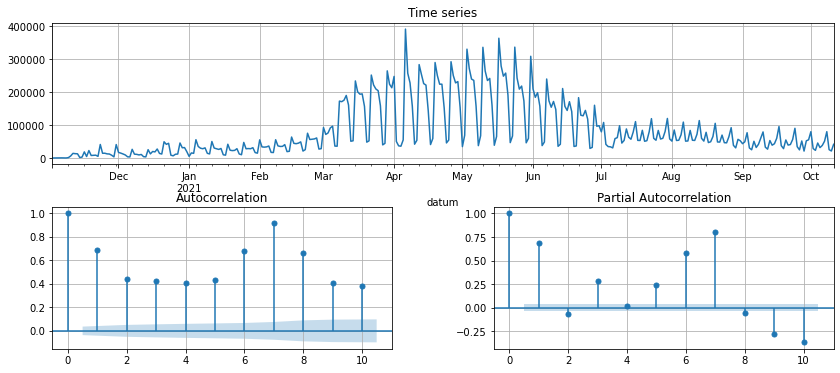

In [3]:
df = data['prirustkovy_pocet_provedenych_ag_testu'].last('50W')
df = df.asfreq('D')

tsplot(df, lags=10)

Jelikož jsme se zatím neseznámili s problematikou sezónnosti, budeme pracovat na týdenních součtech. To může být dokonce vhodné, neboť tím dostáváme poměrně rozumná data, která nevyžadují komplexní model a současně dokážou schovat různé anomálie. Podobně může být praktické pracovat na průměrech apod.

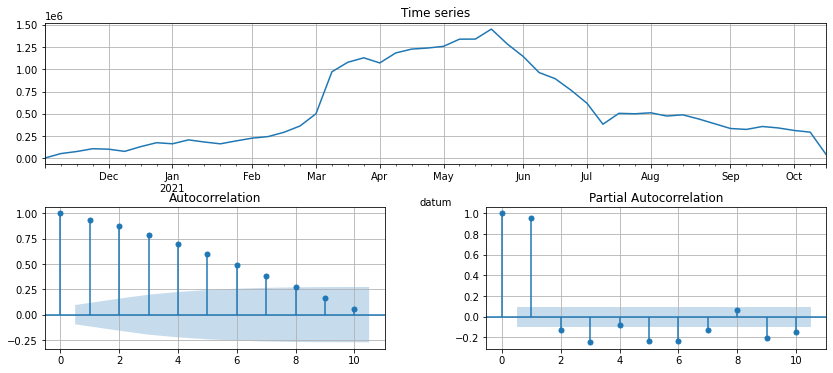

In [4]:
df_analysis = df.resample('W').sum()
tsplot(df_analysis, lags=10)

Tentokrát už víme, že hodnoty v prvním lagu PACF blízké 1 indikují přítomnost trendu v datech. Můžeme se jej zkusit zbavit například populárním diferencováním, které v našem případě znamená


``df_analysis_d1(t) = df_analysis(t) - df_analysis(t-1)``

Vlastně tím odstraňujeme něco podobného náhodné procházce, co vzniklo opačným procesem - integrováním.

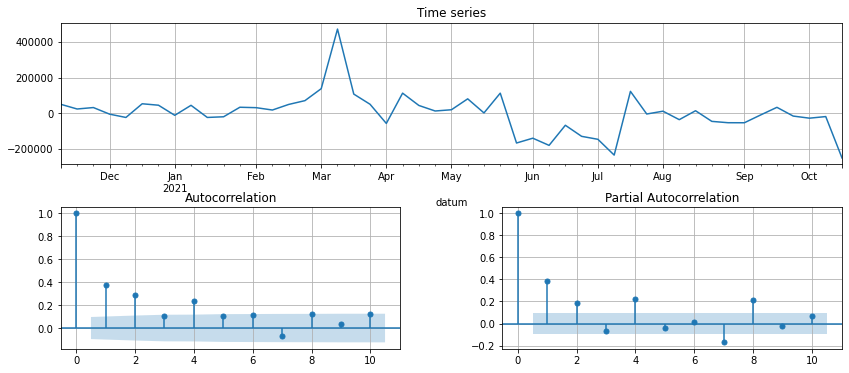

In [5]:
df_analysis_d1 = df_analysis.diff().dropna()
tsplot(df_analysis_d1, lags=10)

Zdá se, že se podařilo trendu zbavit, akorát nám stále zbývá několik významných lagů. Můžeme zkusit ještě jedno diferencování a uvidíme. Každopádně hodnoty v PACF nám tuto potřebu moc neindikují.

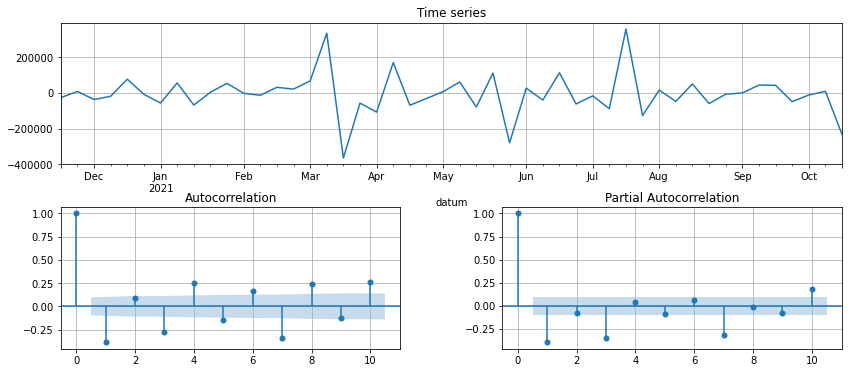

In [6]:
df_analysis_d2 = df_analysis_d1.diff().dropna()
tsplot(df_analysis_d2, lags=10)

Opravdu jsme nic nezískali. Zůstali bychom tedy u prvních diferencí a dataframu `df_analysis_d1`. Jelikož máme diferencováno, zajímal by nás ideální model. Ten můžeme zkusit najít pomocí `arma_order_select_ic()` jako posledně:

In [7]:
arma_order_select_ic(df_analysis_d1, ic='aic', trend='c')

{'aic':              0            1            2
 0  1279.940478  1276.597944  1273.985592
 1  1273.644623  1274.415225  1275.803641
 2  1274.192350  1272.321547  1274.321094
 3  1275.898760  1274.321278  1276.099980
 4  1275.468422  1275.911904  1277.681588,
 'aic_min_order': (2, 1)}

Nyní můžeme buď fitovat ARMA(p,q), nebo se vrátit k původním datům před diferencováním a zkusit ARIMA(p,d,q). Asi lepší bude se vrátit, ostatně půjdou nám lépe i predikce schované v příslušné třídě a nebudeme muset predikce ARMA modelu integrovat.

In [8]:
model = ARIMA(df_analysis, order=(2,1,1), trend='n')
res = model.fit()
print(res.summary())

                                         SARIMAX Results                                          
Dep. Variable:     prirustkovy_pocet_provedenych_ag_testu   No. Observations:                   50
Model:                                     ARIMA(2, 1, 1)   Log Likelihood                -631.342
Date:                                    Tue, 12 Oct 2021   AIC                           1270.684
Time:                                            11:45:40   BIC                           1278.251
Sample:                                        11-08-2020   HQIC                          1273.555
                                             - 10-17-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4347      0.182     -2.389      0

Projděte si výsledky z odhadu modelu a interpretujte je!

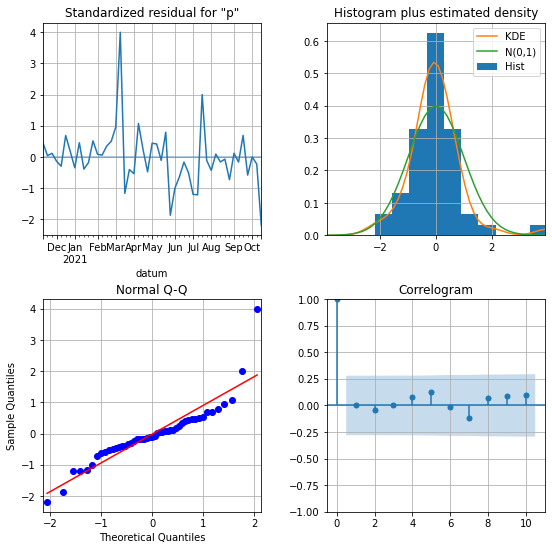

In [9]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Zkusíme napočítat predikce:

In [10]:
preds = res.get_prediction(end='2021-11-01')
preds.summary_frame().head()

prirustkovy_pocet_provedenych_ag_testu,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-11-08,0.000000,119321.455271,-233865.754915,233865.754915
2020-11-15,4437.746671,107179.337684,-205629.895077,214505.388419
2020-11-22,71539.670185,105772.511410,-135770.642733,278849.983103
2020-11-29,95230.540715,104830.761581,-110233.976455,300695.057885
2020-12-06,116189.039197,104173.733199,-87987.726009,320365.804402


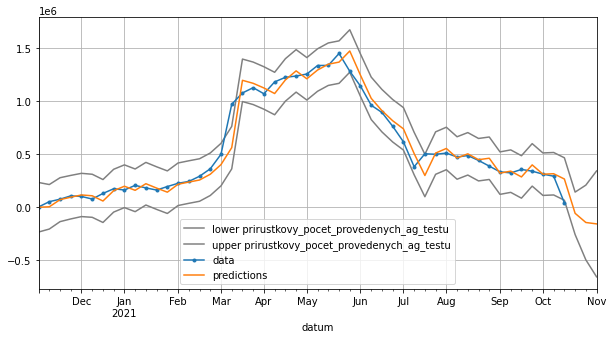

In [11]:
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(10, 5))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
plt.legend()
plt.show()

### Odhad řádů pomocí `pmdarima`

Odhad řádů (p,d,q) byl doposud systémem pokus-omyl. Balík [`pmdarima`](https://alkaline-ml.com/pmdarima/index.html) umožňuje tuto činnost poměrně značně zjednodušit, a sice metodou `auto_arima()` inspirovanou v R. Metoda má vcelku dost parametrů, zkusíme si odhadnout ideální řád s kritériem BIC.

In [57]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(df_analysis, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='bic')  # set to stepwise

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1282.023, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1283.724, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1279.148, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1282.413, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1279.845, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=1281.576, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=1282.114, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=1275.266, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=1277.701, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1278.085, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1278.520, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=1278.251, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.184 seconds


Ten můžeme následně nafitovat pomocí `ARIMA()`. `pmdarima` umožňuje pokračovat s ní, ale pro přímočarost zůstaňme u `statsmodels`:

In [58]:
model2 = ARIMA(df_analysis, order=(1,1,0), trend='n')
res2 = model2.fit()
print(res2.summary())

                                         SARIMAX Results                                          
Dep. Variable:     prirustkovy_pocet_provedenych_ag_testu   No. Observations:                   50
Model:                                     ARIMA(1, 1, 0)   Log Likelihood                -633.741
Date:                                    Tue, 12 Oct 2021   AIC                           1271.483
Time:                                            12:12:03   BIC                           1275.266
Sample:                                        11-08-2020   HQIC                          1272.918
                                             - 10-17-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4221      0.102      4.126      0

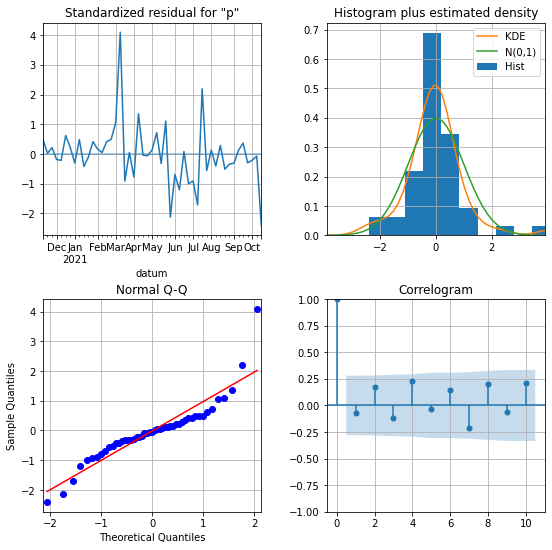

In [59]:
res2.plot_diagnostics(figsize=(9,9))
plt.show()

In [61]:
preds2 = res2.get_prediction(end='2021-11-01')

Vykreslíme si výsledky predikcí a zahrneme bodové predikce i z předchozího modelu:

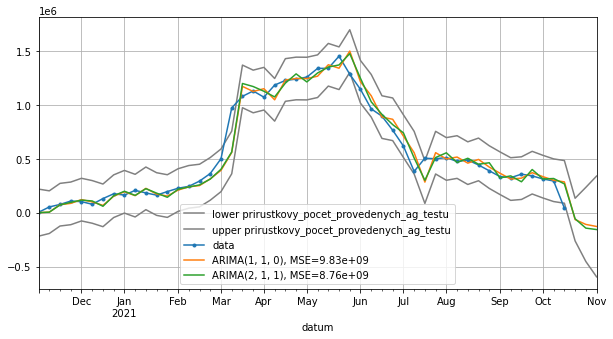

In [63]:
ci2 = preds2.conf_int()

fig = ci2.plot(color='grey', figsize=(10, 5))
res2.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds2.predicted_mean.plot(label='ARIMA' + str(res2.specification.order) 
                           + f', MSE={res2.mse:.3g}', fig=fig)
preds.predicted_mean.plot(label='ARIMA' + str(res.specification.order)
                          + f', MSE={res.mse:.3g}', fig=fig)
plt.legend()
plt.show()